## Description about this notebook
This notebook is designed to visually compare the performance of our three different YOLO NAS models (Small, Medium, Large) in terms of two key metrics: Mean Average Precision at 50% (MAP50) and Mean Average Precision from 50% to 95% (MAP50:95). We employed a supervision function for this evaluation. The assessment was carried out on a test dataset, which was not previously exposed to the models. This test dataset is unique as it comprises a new blend of Jersey and Holstein cow images, captured from two distinct camera perspectives: top and side views. This setup ensures a comprehensive evaluation of the models' ability to accurately detect and recognize objects in varied and realistic scenarios.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING to ignore INFO messages
logging.basicConfig(level=logging.WARNING)


from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/Users/mautushid/github/Cowsformer


In [3]:
from models.nas import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import os

# Directory containing all the checkpoints
checkpoints_dir = ROOT + "/checkpoints_breed"

# Function to sort and organize checkpoint paths into the specified format
def organize_checkpoints_corrected(checkpoints_dir):
    # Dictionary to hold the paths categorized by category, then by type
    categorized_paths = {}

    # Iterate through each subdirectory in the checkpoints directory
    for sub_dir in os.listdir(checkpoints_dir):
        # Construct the full path of the subdirectory
        full_sub_dir_path = os.path.join(checkpoints_dir, sub_dir)
        # Check if the current path is a directory
        if os.path.isdir(full_sub_dir_path):
            # Extract category, iteration, and type from the folder name
            parts = sub_dir.split('_')
            category = parts[0]  # e.g., n10
            size_type = parts[-3][-1]  # Assuming type is represented by the last letter before the category and iteration

            # Validate size_type to be 's', 'm', or 'l'
            if size_type not in ['s', 'm', 'l']:
                continue  # Skip if size_type does not match expected values
            
            # Iterate through the RUN_... directory inside the current subdirectory
            for run_dir in os.listdir(full_sub_dir_path):
                run_dir_path = os.path.join(full_sub_dir_path, run_dir)
                if os.path.isdir(run_dir_path):
                    # Construct the path to the ckpt_best.pth file inside the RUN_... directory
                    ckpt_path = os.path.join(run_dir_path, 'ckpt_best.pth')
                    if os.path.exists(ckpt_path):
                        # Initialize the nested dictionaries and lists as needed
                        if category not in categorized_paths:
                            categorized_paths[category] = {'s': [], 'm': [], 'l': []}
                        categorized_paths[category][size_type].append(ckpt_path)

    # Sort paths within each list
    for category in categorized_paths.keys():
        for size_type in categorized_paths[category].keys():
            categorized_paths[category][size_type].sort()

    return categorized_paths

# Call the function and print the organized checkpoint paths
organized_paths = organize_checkpoints_corrected(checkpoints_dir)
for category, types in organized_paths.items():
    print(f"{category}:")
    for size_type, paths in types.items():
        print(f"  {size_type}:")
        for path in paths:
            print(f"    {path}")


n100:
  s:
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i1_exp_yolo_nas_s_100_1/RUN_20240208_031031_042286/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i2_exp_yolo_nas_s_100_2/RUN_20240208_095332_321300/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i3_exp_yolo_nas_s_100_3/RUN_20240208_170808_999241/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i4_exp_yolo_nas_s_100_4/RUN_20240209_003607_035968/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i5_exp_yolo_nas_s_100_5/RUN_20240209_081721_694681/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i6_exp_yolo_nas_s_100_6/RUN_20240209_151823_199756/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/checkpoints_breed/n100_yolo_na_i7_exp_yolo_nas_s_100_7/RUN_20240209_223716_400965/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/check

In [16]:
#organized_paths

In [17]:
n10_s_path = organized_paths['n10']['s']
n10_m_path = organized_paths['n10']['m']
n10_l_path = organized_paths['n10']['l']

n25_s_path = organized_paths['n200']['s']
n25_m_path = organized_paths['n200']['m']
n25_l_path = organized_paths['n200']['l']

n50_s_path = organized_paths['n200']['s']
n50_m_path = organized_paths['n200']['m']
n50_l_path = organized_paths['n200']['l']

n100_s_path = organized_paths['n200']['s']
n100_m_path = organized_paths['n200']['m']
n100_l_path = organized_paths['n200']['l']

n200_s_path = organized_paths['n200']['s']
n200_m_path = organized_paths['n200']['m']
n200_l_path = organized_paths['n200']['l']

In [18]:
path_model_s = 'yolo_nas_s'
path_model_m = 'yolo_nas_m'
path_model_l = 'yolo_nas_l'
dir_train = "/Users/mautushid/github/Cowsformer/data/breed/train"
dir_val = "/Users/mautushid/github/Cowsformer/data/breed/val"
dir_test = "/Users/mautushid/github/Cowsformer/data/breed/test"
name_task = "breed"
data_yaml_path = "/Users/mautushid/github/Cowsformer/data/breed/data.yaml"

def evaluate_models_s(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_s, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_s, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_m(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_m, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_m, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_l(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_l, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_l, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

In [19]:
evaluattion_results_n10_s_path = evaluate_models_s(n10_s_path)
evaluattion_results_n10_m_path = evaluate_models_m(n10_m_path)
evaluattion_results_n10_l_path = evaluate_models_l(n10_l_path)

evaluattion_results_n25_s_path = evaluate_models_s(n25_s_path)
evaluattion_results_n25_m_path = evaluate_models_m(n25_m_path)
evaluattion_results_n25_l_path = evaluate_models_l(n25_l_path)

evaluattion_results_n50_s_path = evaluate_models_s(n50_s_path)
evaluattion_results_n50_m_path = evaluate_models_m(n50_m_path)
evaluattion_results_n50_l_path = evaluate_models_l(n50_l_path)

evaluattion_results_n100_s_path = evaluate_models_s(n100_s_path)
evaluattion_results_n100_m_path = evaluate_models_m(n100_m_path)
evaluattion_results_n100_l_path = evaluate_models_l(n100_l_path)

evaluattion_results_n200_s_path = evaluate_models_s(n200_s_path)
evaluattion_results_n200_m_path = evaluate_models_m(n200_m_path)
evaluattion_results_n200_l_path = evaluate_models_l(n200_l_path)

[2024-02-11 17:49:41] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-11 17:49:41] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-11 17:49:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i1_exp_yolo_nas_s_10_1/RUN_20240207_230557_230082/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i2_exp_yolo_nas_s_10_2/RUN_20240208_055127_814659/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i3_exp_yolo_nas_s_10_3/RUN_20240208_124409_189617/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i4_exp_yolo_nas_s_10_4/RUN_20240208_195853_295825/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i5_exp_yolo_nas_s_10_5/RUN_20240209_034220_760214/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i6_exp_yolo_nas_s_10_6/RUN_20240209_111143_330032/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i7_exp_yolo_nas_s_10_7/RUN_20240209_181242_642337/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i8_exp_yolo_nas_s_10_8/RUN_20240210_012932_686568/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:49:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:49:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:49:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:49:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:49:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:49:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:49:46] INFO -

model yolo_nas_m loaded


[2024-02-11 17:51:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i2_exp_yolo_nas_m_10_2/RUN_20240208_060744_061478/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:51:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i3_exp_yolo_nas_m_10_3/RUN_20240208_130129_875451/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:51:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i4_exp_yolo_nas_m_10_4/RUN_20240208_201552_062449/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:51:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i5_exp_yolo_nas_m_10_5/RUN_20240209_035950_574032/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:51:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i6_exp_yolo_nas_m_10_6/RUN_20240209_112728_999871/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:51:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i7_exp_yolo_nas_m_10_7/RUN_20240209_182919_245392/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:51:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i8_exp_yolo_nas_m_10_8/RUN_20240210_014528_441682/ckpt_best.pth EMA checkpoint.
[2024-02-11 17:51:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 17:51:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:51:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:51:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:51:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:51:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:51:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:51:20] INFO -

model yolo_nas_l loaded


[2024-02-11 17:53:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i2_exp_yolo_nas_l_10_2/RUN_20240208_063649_468999/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 17:53:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i3_exp_yolo_nas_l_10_3/RUN_20240208_133216_655515/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 17:53:30] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i4_exp_yolo_nas_l_10_4/RUN_20240208_204715_016637/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 17:53:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i5_exp_yolo_nas_l_10_5/RUN_20240209_043417_693711/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 17:53:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i6_exp_yolo_nas_l_10_6/RUN_20240209_115808_872395/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 17:53:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i7_exp_yolo_nas_l_10_7/RUN_20240209_190256_387345/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 17:53:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n10_yolo_na_i8_exp_yolo_nas_l_10_8/RUN_20240210_021652_657045/ckpt_best.pth EMA checkpoint.
[2024-02-11 17:53:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 17:53:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:53:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:53:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:53:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:53:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:53:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:53:37] INFO -

model yolo_nas_s loaded


[2024-02-11 17:56:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:56:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:56:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:56:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:56:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:56:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 17:56:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.
[2024-02-11 17:56:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 17:56:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:56:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:56:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:56:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:56:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:56:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:56:27] INFO -

model yolo_nas_m loaded


[2024-02-11 17:57:55] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:57:56] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:57:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:57:57] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:57:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:57:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 17:58:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.
[2024-02-11 17:58:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 17:58:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:58:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:58:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:58:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:58:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:58:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 17:58:02] INFO -

model yolo_nas_l loaded


[2024-02-11 18:00:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:00:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:00:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:00:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:00:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:00:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:00:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:00:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 18:00:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:00:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:00:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:00:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:00:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:00:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:00:17] INFO -

model yolo_nas_s loaded


[2024-02-11 18:02:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:02:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:02:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:02:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:02:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:03:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:03:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:03:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 18:03:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:03:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:03:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:03:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:03:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:03:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:03:02] INFO -

model yolo_nas_m loaded


[2024-02-11 18:04:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:04:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:04:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:04:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:04:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:04:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:04:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:04:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 18:04:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:04:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:04:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:04:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:04:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:04:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:04:28] INFO -

model yolo_nas_l loaded


[2024-02-11 18:06:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:06:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:06:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:06:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:06:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:06:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:06:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:06:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 18:06:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:06:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:06:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:06:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:06:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:06:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:06:46] INFO -

model yolo_nas_s loaded


[2024-02-11 18:09:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:09:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:09:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:09:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:09:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:09:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:09:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:09:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 18:09:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:09:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:09:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:09:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:09:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:09:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:09:44] INFO -

model yolo_nas_m loaded


[2024-02-11 18:11:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:11:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:11:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:11:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:11:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:11:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:11:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:11:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 18:11:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:11:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:11:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:11:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:11:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:11:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:11:15] INFO -

model yolo_nas_l loaded


[2024-02-11 18:13:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:13:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:13:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:13:30] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:13:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:13:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:13:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:13:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 18:13:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:13:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:13:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:13:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:13:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:13:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:13:36] INFO -

model yolo_nas_s loaded


[2024-02-11 18:16:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:16:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:16:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:16:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:16:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:16:30] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 18:16:30] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:16:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 18:16:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:16:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:16:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:16:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:16:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:16:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:16:32] INFO -

model yolo_nas_m loaded


[2024-02-11 18:17:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:17:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:18:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:18:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:18:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:18:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 18:18:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:18:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 18:18:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:18:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:18:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:18:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:18:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:18:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:18:05] INFO -

model yolo_nas_l loaded


[2024-02-11 18:20:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:20:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:20:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:20:20] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:20:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:20:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 18:20:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.
[2024-02-11 18:20:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 18:20:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:20:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:20:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:20:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 18:20:26] INFO -

In [29]:
evaluattion_results_n10_s_path

[{'mAP@50': 0.6835617883229721, 'mAP@50:95': 0.4032472635528922},
 {'mAP@50': 0.6461464676991999, 'mAP@50:95': 0.3712608685546753},
 {'mAP@50': 0.6786852979229533, 'mAP@50:95': 0.39892146713417315},
 {'mAP@50': 0.66387977828549, 'mAP@50:95': 0.36658592964828884},
 {'mAP@50': 0.7146471675619264, 'mAP@50:95': 0.4267374456030287},
 {'mAP@50': 0.6778077798739823, 'mAP@50:95': 0.3917597435908492},
 {'mAP@50': 0.676314389231125, 'mAP@50:95': 0.3939352518804675},
 {'mAP@50': 0.691441047380065, 'mAP@50:95': 0.4095002246349778}]

In [30]:
evaluattion_results_n10_m_path

[{'mAP@50': 0.7272012531083425, 'mAP@50:95': 0.4363663816751725},
 {'mAP@50': 0.7324984107458831, 'mAP@50:95': 0.44473119089688284},
 {'mAP@50': 0.727082473298013, 'mAP@50:95': 0.44232146187036536},
 {'mAP@50': 0.7407656952045123, 'mAP@50:95': 0.4516199991641384},
 {'mAP@50': 0.7585379311068474, 'mAP@50:95': 0.45112287735093204},
 {'mAP@50': 0.7229206937694578, 'mAP@50:95': 0.44616569407463935},
 {'mAP@50': 0.754309196752544, 'mAP@50:95': 0.45732225106354907},
 {'mAP@50': 0.6991006762191626, 'mAP@50:95': 0.40569141626275523}]

In [10]:
evaluattion_results_n10_l_path

[{'mAP@50': 0.7712637379483775, 'mAP@50:95': 0.4816721347225269},
 {'mAP@50': 0.7598732473306556, 'mAP@50:95': 0.4675498567089451},
 {'mAP@50': 0.7498658433976457, 'mAP@50:95': 0.4588825527900692},
 {'mAP@50': 0.7480903586670188, 'mAP@50:95': 0.4693490411163944},
 {'mAP@50': 0.7475380903064905, 'mAP@50:95': 0.4526884731417621},
 {'mAP@50': 0.7661993525686798, 'mAP@50:95': 0.48255732673322366},
 {'mAP@50': 0.7577541681711821, 'mAP@50:95': 0.4754896405088263},
 {'mAP@50': 0.741624695427037, 'mAP@50:95': 0.48401746686619507}]

In [12]:
evaluattion_results_n200_s_path

[{'mAP@50': 0.6924668672965916, 'mAP@50:95': 0.41269289282134897},
 {'mAP@50': 0.7040475977903323, 'mAP@50:95': 0.4022256691111964},
 {'mAP@50': 0.7344376442385886, 'mAP@50:95': 0.4287147177612115},
 {'mAP@50': 0.692610655402438, 'mAP@50:95': 0.39781384533429603},
 {'mAP@50': 0.7054723524430508, 'mAP@50:95': 0.40950130132869084},
 {'mAP@50': 0.7005177425837352, 'mAP@50:95': 0.41106172875704183},
 {'mAP@50': 0.6929479911375864, 'mAP@50:95': 0.43011120560888016},
 {'mAP@50': 0.6181412138402596, 'mAP@50:95': 0.34788373420499924}]

In [13]:
evaluattion_results_n200_m_path

[{'mAP@50': 0.7340927639996407, 'mAP@50:95': 0.4398045267251522},
 {'mAP@50': 0.718186679481636, 'mAP@50:95': 0.4380870708516955},
 {'mAP@50': 0.7347565387061724, 'mAP@50:95': 0.438906463818902},
 {'mAP@50': 0.7161658662077577, 'mAP@50:95': 0.4398596142193334},
 {'mAP@50': 0.7331397617955226, 'mAP@50:95': 0.44990566891356343},
 {'mAP@50': 0.6946872568469958, 'mAP@50:95': 0.42957409578707983},
 {'mAP@50': 0.7569974765096135, 'mAP@50:95': 0.4591112693109524},
 {'mAP@50': 0.7470317428658497, 'mAP@50:95': 0.4565906024396365}]

In [21]:
evaluattion_results_n200_l_path

[{'mAP@50': 0.7561147685049352, 'mAP@50:95': 0.46746450209220847},
 {'mAP@50': 0.7762585938052582, 'mAP@50:95': 0.47123034897179916},
 {'mAP@50': 0.7644738832921594, 'mAP@50:95': 0.4663504339140404},
 {'mAP@50': 0.7658680970421083, 'mAP@50:95': 0.4795955276171357},
 {'mAP@50': 0.756416352544927, 'mAP@50:95': 0.472225290292438},
 {'mAP@50': 0.7605211438559463, 'mAP@50:95': 0.47689606149110475},
 {'mAP@50': 0.7531166628399859, 'mAP@50:95': 0.46539298725956557},
 {'mAP@50': 0.7491854894738921, 'mAP@50:95': 0.45537823118023046}]

In [22]:
import numpy as np

# Example dataset for evaluattion_results_n200_l_path


# Extracting mAP@50 and mAP@50:95 values
map50_values = [result['mAP@50'] for result in evaluattion_results_n100_l_path]
map5095_values = [result['mAP@50:95'] for result in evaluattion_results_n100_l_path]

# Calculating medians
median_map50 = np.median(map50_values)
median_map5095 = np.median(map5095_values)

median_map50, median_map5095


(0.7584687482004366, 0.4693474255320038)

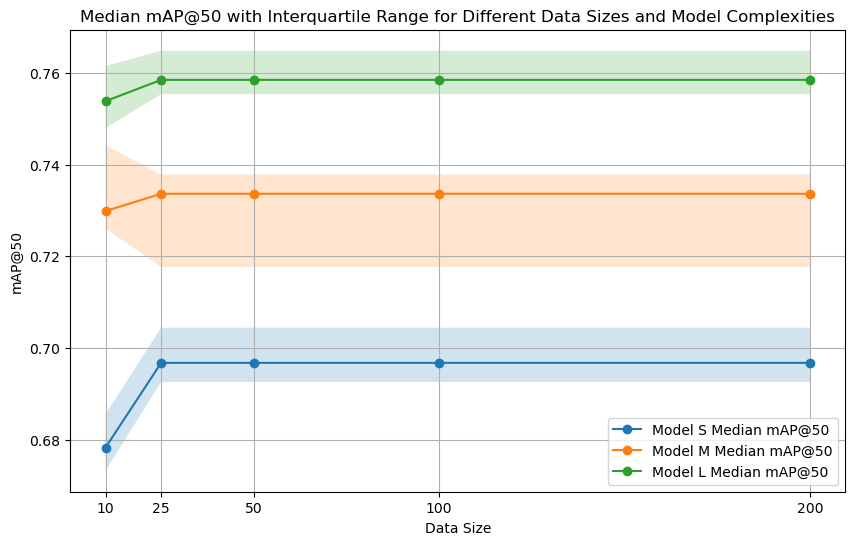

In [27]:
import numpy as np

evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    median_map50 = np.median(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'median': median_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the median values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    median_values = [evaluation_statistics[key]['median'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the median line
    ax.plot(data_sizes, median_values, marker='o', label=f'Model {model_size.upper()} Median mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Median mAP@50 with Interquartile Range for Different Data Sizes and Model Complexities')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks(sorted(set(data_sizes))) # Set x-ticks to unique sorted data sizes
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


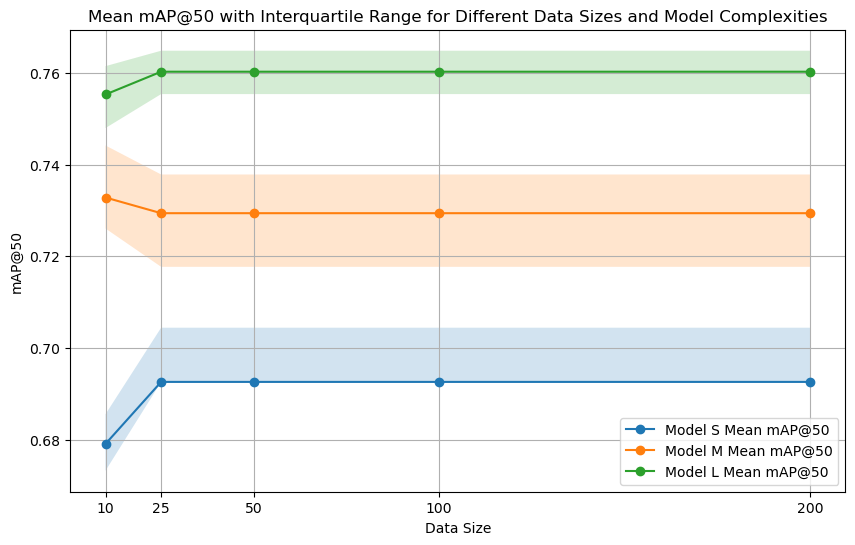

In [25]:
# Replace these lines with your actual evaluation data
evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    mean_map50 = np.mean(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'mean': mean_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    mean_values = [evaluation_statistics[key]['mean'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the mean line
    ax.plot(data_sizes, mean_values, marker='o', label=f'Model {model_size.upper()} Mean mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Mean mAP@50 with Interquartile Range for Different Data Sizes and Model Complexities')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks(sorted(set(data_sizes))) # Set x-ticks to unique sorted data sizes
ax.legend()
ax.grid(True)

# Show the plot
plt.show()
